# Problem 1 (24 points)

## Problem Description
A projectile is launched with input x- and y-velocity components. A dataset is provided, which contains launch velocity components as input and whether a target was hit (0/1) as an output. This data has a nonlinear decision boundary. 

You will use gradient descent to train a logistic regression model on the dataset to predict whether any given launch velocity will hit the target.



Fill out the notebook as instructed, making the requested plots and printing necessary values. 

*You are welcome to use any of the code provided in the previous problems.*

#### Summary of deliverables:
Functions (described in later section)
- `sigmoid(h)`
- `map_features(data)`
- `loss(data,y,w)`
- `grad_loss(data,y,w)`
- `grad_desc(data, y, w0, iterations, stepsize)`

Results:
- Print final `w` after training on the training data
- Plot of loss throughout training
- Print model percent classification accuracy on the training data
- Print model percent classification accuracy on the testing data
- Plot that shows the training data as data points, along with a decision boundary

#### Imports and Utility Functions:


In [140]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data(data, c, title="", xlabel="$x_1$",ylabel="$x_2$",classes=["",""],alpha=1):
    N = len(c)
    colors = ['royalblue','crimson']
    symbols = ['o','s']
    
    plt.figure(figsize=(5,5),dpi=120)

    for i in range(2):
        x = data[:,0][c==i]
        y = data[:,1][c==i]

        plt.scatter(x,y,color=colors[i],marker=symbols[i],edgecolor="black",linewidths=0.4,label=classes[i],alpha=alpha)

    plt.legend(loc="upper right")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = plt.gca()
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.title(title)

def plot_contour(w):
    res = 500
    vals = np.linspace(-0.05,1.05,res)
    x,y = np.meshgrid(vals,vals)
    XY = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
    prob = sigmoid(map_features(XY) @ w.reshape(-1,1))
    pred = np.round(prob.reshape(res, res))
    plt.contour(x, y, pred)


## Load Data
This cell loads the dataset into the following variables:
- `train_data`: Nx2 array of input features, used for training
- `train_gt`: Array of ground-truth classes for each point in `train_data`
- `test_data`: Nx2 array of input features, used for testing
- `test_gt`: Array of ground-truth classes for each point in `test_data`



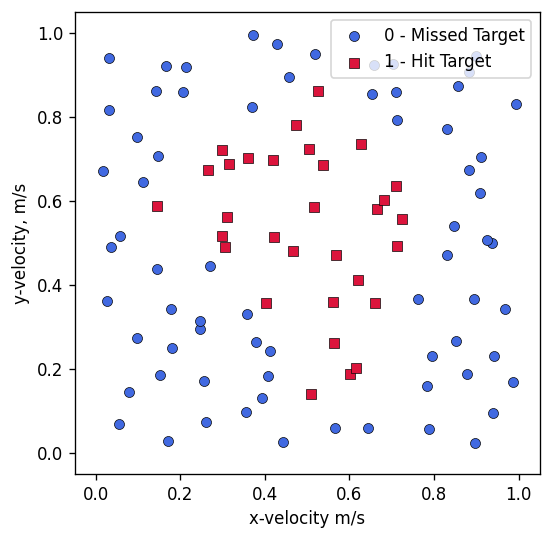

In [141]:
train = np.load("data/w3-hw1-data-train.npy")
test = np.load("data/w3-hw1-data-test.npy")
train_data, train_gt = train[:,:2], train[:,2]
test_data, test_gt = test[:,:2], test[:,2]
format = dict(xlabel="x-velocity m/s", ylabel="y-velocity, m/s", classes=["0 - Missed Target","1 - Hit Target"])
plot_data(train_data, train_gt, **format)

## Helper Functions
Here, implement the following functions:  

**`sigmoid(h)`**:
- Input: `h`, single value or array of values
- Returns: The sigmoid of h (or each value in h)

**`map_features(data)`**:
- Input: `data`, Nx2 array with rows $(x_i,y_i)$
- Returns: Nx45 array, each row with $(1, x_i,\; y_i,\; x_i^2,\; x_i y_i,\; y_i^2,\; x_i^3,\; x_i^2 y_i,\; ...)$ with all terms through 8th-order

**`loss(data, y, w)`**:
- Input: `data`, Nx2 array of un-transformed input features
- Input: `y`, Ground truth class for each input
- Input: `w`, Array with 45 weights
- Returns: Loss: $ L(x,y,w) = \sum_{i=1}^n -y^{(i)} \cdot \ln(g(w'x^{(i)})) - (1 - y^{(i)}) \cdot \ln(1 - g(w'x^{(i)})) $

**`grad_loss(data, y, w)`**:
- Input: `data`, Nx2 array of un-transformed input features
- Input: `y`, Ground truth class for each input
- Input: `w`, Array with 45 weights
- Returns: Gradient of loss with respect to weights: $ \frac{\partial L}{w_j} = \sum_{i=1}^n (g(w'x^{(i)}) - y^{(i)}) x_j^{(i)} $


deg_x= 0 | 1   | 2     | 3       | 4
deg_y= 0 | 0,1 | 0,1,2 | 0,1,2,3 | 

In [142]:
# YOUR CODE GOES HERE
def sigmoid(h):
    sig = 1/(1 + np.exp(-h))

    return sig


def map_features(data):
    features = np.zeros([len(data[:, 0]), 45])
    xs = data[:, 0]
    ys = data[:, 1]
    features[:, 0] = np.zeros([len(data[:, 0]), 1]).flatten()
    count = 1

    for i in range(9):
        for j in range(i + 1):
            for k in range(i + 1):
                if(j + k == i and j + k != 0):
                    features[:, count] = np.multiply(np.power(xs, j), np.power(ys, k))
                    count += 1

    return features


def transform(data, w):
    features = map_features(data)
    h = features @ w

    return h


def loss(data, y, w):
    features = map_features(data)
    J = 0
    J1 = 0
    J2 = 0

    for i in range(len(y)):
        J1 += y[i] * (- np.log(sigmoid(features[i, :] @ w)))
        J2 += (1 - y[i]) * (- np.log(1 - sigmoid(features[i, :] @ w)))
        J += J1 + J2
    
    return J


def grad(data, y, w):
    x_w = transform(data, w)
    features = map_features(data)
    gradient = np.zeros([45, 1])
    g = 0

    for i in range(45):
        for j in range(len(y)):
            g += (sigmoid(x_w[j]) - y[j]) * features[j, i]
        gradient[i] = g
    return gradient


## Gradient Descent
Now, write a gradient descent function with the following specifications:  


**`grad_desc(data, y, w0, iterations, stepsize)`**:
- Input: `data`, Nx2 array of un-transformed input features
- Input: `y`, array of size N with ground-truth class for each input
- Input: `w0`, array of weights to use as an initial guess (size)
- Input `iterations`, number of iterations of gradient descent to perform
- Input: `stepsize`, size of each gradient descent step
- Return: Final `w` array after last iteration
- Return: Array containing loss values at each iteration


In [143]:
# YOUR CODE GOES HERE
def grad_desc(data, y, w0, iterations, stepsize):
    w = w0
    loss_hist = np.zeros([iterations + 1, 1])
    loss_hist[0] = loss(data, y, w)
    
    for i in range(iterations):
        gradient = grad(data, y, w)
        w = w - stepsize * gradient
        loss_hist[i + 1] = loss(data, y, w)
    
    return w, loss_hist

### Training

Run your gradient descent function and plot the loss as it converges. You may have to tune the step size and iteration count.

Also print the final vector `w`.

In [149]:
# YOUR CODE GOES HERE (training)
w0 = np.zeros([45, 1])
iterations = 10000
stepsize = 1e-2
loss_hist = np.zeros([iterations, 1])

w, loss_hist = grad_desc(train_data, train_gt, w0, iterations, stepsize)

Final w:  [[  0.          -5.99101782 -12.10112491  -7.21592278   8.90526712
    7.76572235   9.44068888  19.4648382   23.87290864  17.34992449
   16.06520508  22.00081849  24.14294505  22.41102602  12.86332893
   10.1937581   13.83031864  15.0613945   13.59649098   9.50544653
   -0.75521828  -3.67397091  -1.25944028  -0.40252455  -1.42930127
   -4.12714289  -8.75136851 -18.42722934 -20.99304412 -19.18638039
  -18.47140694 -19.14234352 -20.95270643 -23.82018724 -28.17548695
  -36.69961034 -38.672274   -37.14614854 -36.46015544 -36.86353798
  -38.11063737 -40.01708438 -42.6211497  -46.40804292 -53.63043726]]


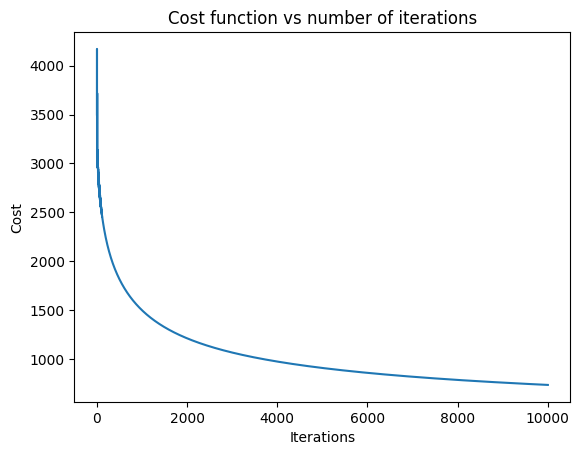

In [150]:
# YOUR CODE GOES HERE (loss plot, print w)
iterator = np.linspace(0, iterations, len(loss_hist))

plt.plot(iterator, loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost function vs number of iterations')
plt.show

print('Final w: ', w.T)

## Accuracy
Compute the accuracy of the model, as a percent, for both the training data and testing data

In [155]:
# YOUR CODE GOES HERE
# predictions for train data
x_w_train = transform(train_data, w)
preds_train = sigmoid(x_w_train)
predictions_train = np.where(preds_train >= 0.5, 1, 0)
print('Ground truth for training data: ', train_gt.T)
print('Predicted values for training data: ', predictions_train.T)
accuracy_train = np.sum(predictions_train.T == train_gt) / len(train_gt) * 100
print('Accuracy for training data: ', accuracy_train)

# predictions for test data
x_w_test = transform(test_data, w)
preds_test = sigmoid(x_w_test)
predictions_test = np.where(preds_test >= 0.5, 1, 0)
print('\n\nGround truth for test data: ', test_gt.T)
print('\nPredicted values for test data: ', predictions_test.T)
accuracy_test = np.sum(predictions_test.T == test_gt) / len(test_gt) * 100
print('Accuracy for test data: ', accuracy_test)

Ground truth for training data:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Predicted values for training data:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1
  1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0
  1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Accuracy for training data:  96.0


Ground truth for test data:  [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 0.]

Predicted values for test data:  [[0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0]]
Accuracy for test data:  96.0


## Visualize Results

Use the provided plotting utilities to plot the decision boundary with the data.


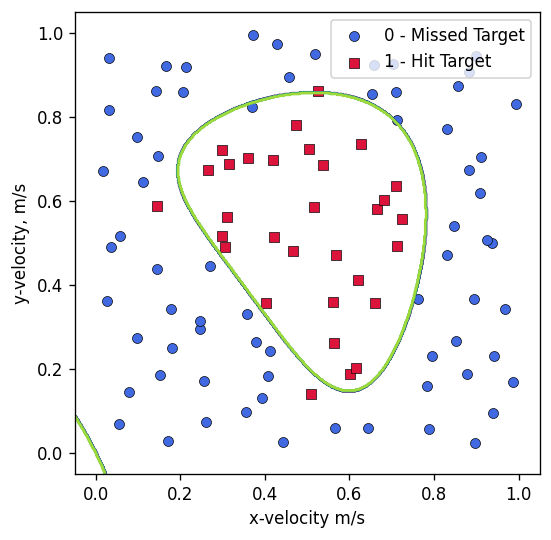

In [156]:
# You may have to modify this code, i.e. if you named 'w' differently)
plot_data(train_data, train_gt, **format)
plot_contour(w)